<a href="https://colab.research.google.com/github/fernanda0402/Doutorado/blob/main/Gaussian_Process_H(z).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Vamos utilizar o Gaussian Process GaPP para trabalhar com dados de $H(z)$. Primeiramente, vamos importar e instalar as bibliotecas necessárias.

In [30]:
# Bibliotecas:

import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sp
import scipy.interpolate as interp
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.optimize import curve_fit
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [31]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [32]:
!pip install -q condacolab
import condacolab
condacolab.install()
!mamba install pyccl

✨🍰✨ Everything looks OK!

                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.4.1) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['pyccl']

[+] 0.0s
[+] 0.1s
conda-forge/linux-64  ⣾  
conda-forge/noarch  

In [33]:
import pyccl as ccl

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install git+https://github.com/JCGoran/GaPP@feature/python3#GaPP
from gapp import gp
from numpy import loadtxt, savetxt

Vamos trabalhar com dados de $H(z)$. Primeiramente, vamos obter sua curva de acordo com o Modelo $\Lambda$CDM usando sua definição da biblioteca pyccl.

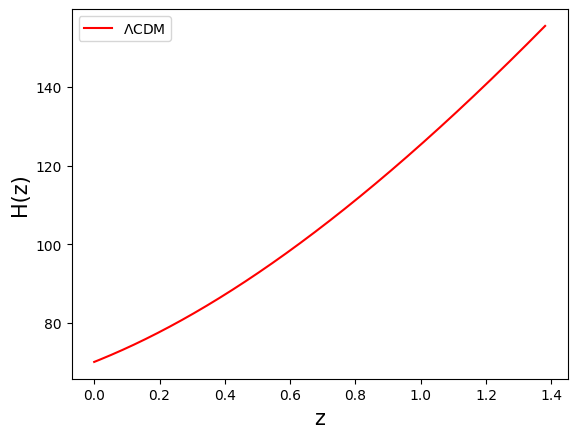

In [36]:
# MODELO LCDM
cosmo = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, w0 = -1, h=0.6727, sigma8=0.8120, n_s=0.9649) 


a = np.linspace(0.42, 1, 1000)  # fator de escala

# definindo o redshift em função do fator de escala
z = (1/a) - 1.

h_lcdm = ccl.h_over_h0(cosmo, a)

h0 = 70 #km/s/Mpc

h_new = h_lcdm * h0

plt.plot(z, h_new, color='red', label='$\Lambda$CDM')
plt.xlabel('z', fontsize=15)
plt.ylabel('H(z)', fontsize=15)
plt.legend(loc='best')
plt.show()

Há outra forma de definirmos $H(z)$, dada por:

$H(z) = H_0 \sqrt{\Omega_{m0} (1+z)^3 + \Omega_{\Lambda 0}}$.

Abaixo, vamos fazer o plot desta expressão.

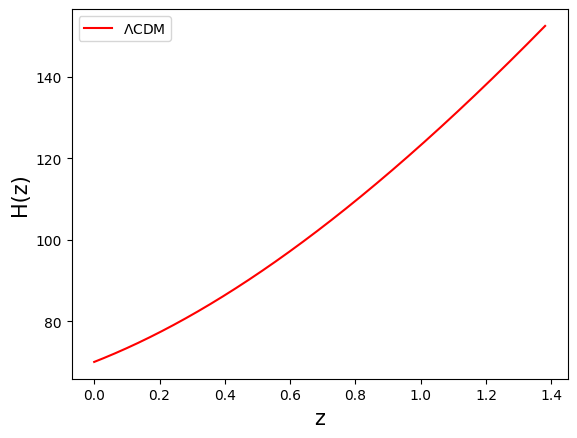

In [37]:
# outra forma de escrever H(z)

# constantes
Om0 = 0.30
O_L0 = 1 - Om0
h0 = 70 #km/s/Mpc


h_1 = h0*(np.sqrt(Om0*((1+z)**3) + O_L0 ))

plt.plot(z, h_1, color='red', label='$\Lambda$CDM')
plt.xlabel('z', fontsize=15)
plt.ylabel('H(z)', fontsize=15)
plt.legend(loc='best')
plt.show()

Vamos fazer a derivada do modelo $\Lambda$CDM, considerando $H(z)$ dada pela expressão que plotamos acima.

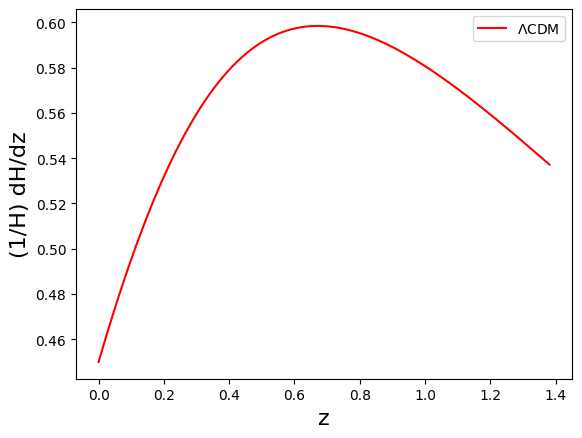

In [38]:
# constantes
Om0 = 0.30
O_L0 = 1 - Om0
h0 = 70 #km/s/Mpc

dh_lcdm = ( (3/2)*h0*Om0*((1+z)**2) )/(np.sqrt(Om0*((1+z)**3) + O_L0 ))

dh_1 = ( (3/2)*Om0*((1+z)**2) )/(Om0*((1+z)**3) + O_L0 )

# plote

plt.plot(z, dh_1, color='red', label='$\Lambda$CDM')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/H) dH/dz', fontsize=16)
plt.legend(loc='best')
plt.show()

Na verdade, queremos obter um ajuste para $\gamma$. Derivando com relação a $z$ a seguinte expressão:

$f = \Omega_m ^\gamma (z)$,

chegamos a

$\frac{f'}{f} = \gamma \frac{\Omega_m '}{\Omega_m}$.

Sabemos que:

$\frac{\Omega_m '}{\Omega_m} = \frac{3}{1+z} - \frac{2H'}{H}$.

Primeiramente, vamos plotar considerando o Modelo $\Lambda$CDM. Estamos considerando $f$ de Linder & Cahn porque sua expressão é uma boa aproximação.

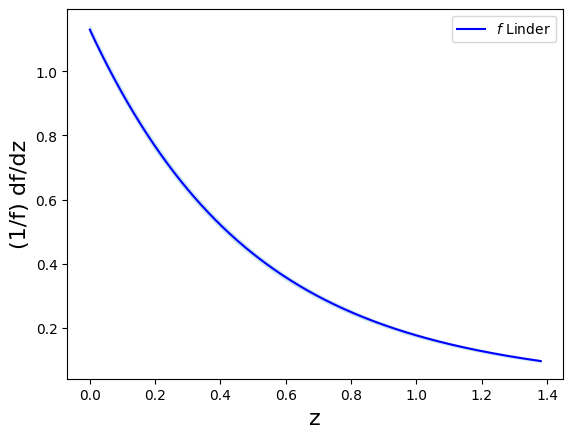

In [53]:
# definindo O_m
Om = (Om0*(a**(-3)))/(Om0*(a**(-3)) + 1 - Om0)
Om0 = 0.315
sigOm0 = 0.007
O_L0 = 1 - Om0
gamma = 0.55

# definindo f conforme linder
f_linder = Om ** gamma

# definindo w0
w0 = -1.028
sig_w0 = 0.031

# derivada de f
derivada_flinder = ( (3 * gamma * O_L0)/( (1+z) * (Om0 * ((1+z)**3) + O_L0) ) )

# definindo o erro de f'/f para Om0
df1 = ( -3*gamma*((1+z)**2) )/(( 1 + Om0*z*(z**2 + 3*z + 3) )**2)

# definindo o erro de f'/f para gamma
df2 = ( (3 * O_L0)/( (1+z) * (Om0 * ((1+z)**3) + O_L0) ) )
siggamma = (3/((6*w0 - 5)**2)) * sig_w0

sig_f1 = np.sqrt( ((df1)*sigOm0)**2 + ((df2)*siggamma)**2 )

# plote
fig, ax = plt.subplots()
plt.plot(z, derivada_flinder, label='$f$ Linder', color='blue')
ax.fill_between(z, derivada_flinder - sig_f1, derivada_flinder + sig_f1, alpha=0.5, color='lightblue')

# legenda, labplt.plot(z, derivada_teo/f, label='derivada teórica', color='red')el e título
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/f) df/dz', fontsize=16)
plt.legend()
plt.show()

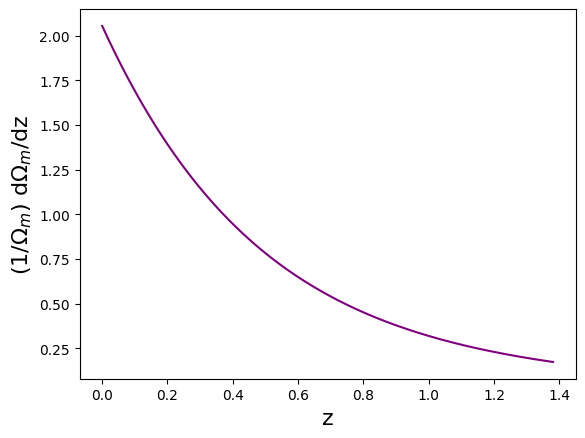

In [40]:
Omega_m = ccl.background.omega_x(cosmo, a, 'matter')
dOmega_m = np.gradient(Omega_m, z)
dOmega_new = dOmega_m / Omega_m


plt.plot(z, dOmega_new, color='purple')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/$\Omega_m$) d$\Omega_m$/dz', fontsize=16)
plt.show()

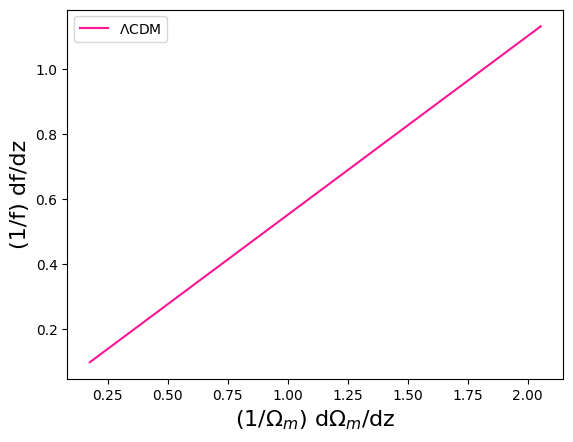

In [41]:
plt.plot(dOmega_new, derivada_flinder, color='deeppink', label='$\Lambda$CDM')

# legenda, label e título
plt.xlabel('(1/$\Omega_m$) d$\Omega_m$/dz', fontsize=16)
plt.ylabel('(1/f) df/dz', fontsize=16)
plt.legend()
plt.show()

Agora, vamos encontrar a razão $\frac{1}{f(z)} \frac{df}{dz}$ a partir da reconstrução dos dados de $f$. Isso já foi feito anteriormente.

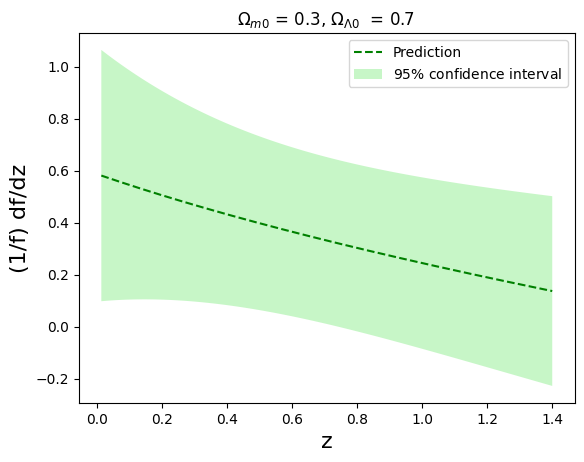

In [42]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# baixando e nomeando dados reconstruídos de f
fz = np.genfromtxt('/content/drive/MyDrive/Doutorado/fz_recon.dat', delimiter='\t')

z_dgapp = fz[:, 0]
f_dgapp = fz[:, 1]

ef = fz[:, 2]

# baixando e nomeando dados reconstruídos da derivada de f
dfz = np.genfromtxt('/content/drive/MyDrive/Doutorado/dfz_recon.dat', delimiter='\t')

z_dfz = dfz[:, 0]

df = dfz[:, 1]

edf = dfz[:, 2]

df_f = df / f_dgapp  # f'/f

sigma_f = np.sqrt(((df_f) ** 2) * (((ef / f_dgapp) ** 2) + ((edf / df) ** 2)))

# PLOTE
plt.plot(z_dgapp, df_f, color='green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([z_dgapp, z_dgapp[::-1]]),
         np.concatenate([df_f - 1.9600 * sigma_f,
                        (df_f + 1.9600 * sigma_f)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label='$95\%$ confidence interval')

# legenda, label e título
plt.title('$\Omega_{m0}$ = 0.3, $\Omega_{\Lambda 0}$  = 0.7 ')
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/f) df/dz', fontsize=16)
plt.legend(loc='best')
plt.show()

# salvando os dados reconstruídos

#H = xi, y_pred, sigma_f
#np.savetxt('df_f_recon.dat', np.transpose(H), delimiter='\t')
#from google.colab import files
#files.download("df_f_recon.dat")

Agora, vamos baixar os dados de $H(z)$.


Optimized hyperparameters:
theta = [134.94426242   1.98775665]


<ipython-input-43-99eb3e69c966>:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(x_h, y_h, e, fmt='r.', color='purple', markersize=10, label='Dados')


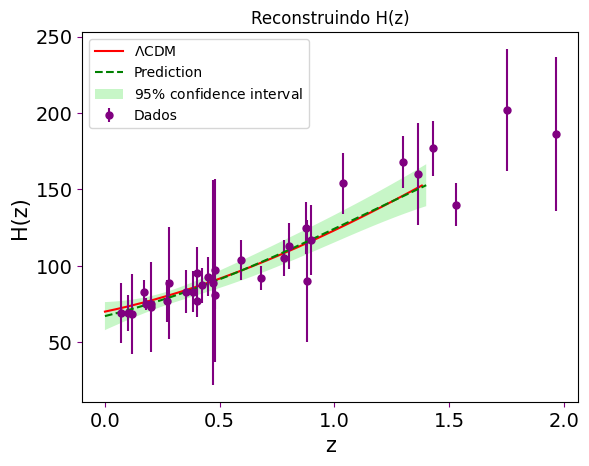

In [43]:
# baixando os dados
data_h = np.genfromtxt('/content/drive/MyDrive/Doutorado/CC_Hz_data.csv', delimiter=', ')

z_h = data_h[:, 0]

h = data_h[:, 1]

sig_h = data_h[:, 2]

# nomeando
x_h = z_h
y_h = h
e = sig_h

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = 0
xmax = 1.4
nstar = 1000

# initial values of the hyperparameters of the squared-exponential covariance function
initheta = [2.0, 2.0]

# initialization of the Gaussian Process
g = gp.GaussianProcess(x_h, y_h, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(rec, theta) = g.gp(theta=initheta)

xi = rec[:, 0]

y_pred = rec[:, 1]
sigma  = rec[:, 2]

y_pred_95_less = y_pred - 1.9600*sigma
y_pred_95_plus = y_pred + 1.9600*sigma

# Plot the function, the prediction and the 95% confidence interval 
plt.figure()
plt.tick_params(labelsize=14, color='purple')
plt.plot(z, h_1, color='red', label='$\Lambda$CDM')
plt.errorbar(x_h, y_h, e, fmt='r.', color='purple', markersize=10, label='Dados')
plt.plot(xi, y_pred, color = 'green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, color = 'lightgreen', ec='None', label=r'$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=15)
plt.ylabel('H(z)', fontsize=15)
plt.legend(loc='best')
plt.title('Reconstruindo H(z)')
plt.show()



# salvando os dados reconstruídos

H = xi, y_pred, sigma
np.savetxt('hz_recon.dat', np.transpose(H), delimiter='\t')
#from google.colab import files
#files.download("hz_recon.dat")

Vamos fazer a primeira derivada usando o GaPP.


Optimized hyperparameters:
theta = [134.94426242   1.98775665]


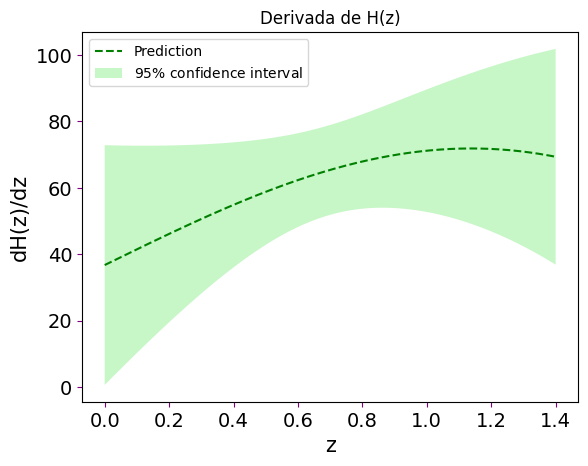

In [44]:
from gapp import dgp # dgp calcula a primeira, segunda e terceira derivada

# baixando os dados reconstruídos de H
data_h = np.genfromtxt('/content/drive/MyDrive/Doutorado/CC_Hz_data.csv', delimiter=', ')

z_h = data_h[:, 0]

h = data_h[:, 1]

sig_h = data_h[:, 2]

# nomeando
x_h = z_h
y_h = h
e = sig_h

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = 0
xmax = 1.4
nstar = 1000

# initial values of the hyperparameters of the squared-exponential covariance function
initheta = [2.0, 2.0]

# initialization of the Gaussian Process
g = dgp.DGaussianProcess(x_h, y_h, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(drec, theta) = g.dgp(theta=initheta)

# the second and third derivatives use g.d2gp() and g.d3gp()

xi     = drec[:, 0]
y_pred = drec[:, 1]
sigma  = drec[:, 2]

y_pred_95_less = y_pred - 1.9600*sigma
y_pred_95_plus = y_pred + 1.9600*sigma



# Plot the function, the prediction and the 95% confidence interval 
plt.figure()
plt.tick_params(labelsize=14, color='purple')
plt.plot(xi, y_pred, color = 'green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, color = 'lightgreen', ec='None', label=r'$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=15)
plt.ylabel('dH(z)/dz', fontsize=15)
plt.legend(loc='best')
plt.title('Derivada de H(z)')
plt.show()

# salvando os dados reconstruídos

dH = xi, y_pred, sigma
np.savetxt('dhz_recon_newz.dat', np.transpose(dH), delimiter='\t')
#from google.colab import files
#files.download("dhz_recon_newz.dat")

Porém, o que realmente queremos plotar é a razão $\frac{1}{H(z)} \frac{dH}{dz}$.

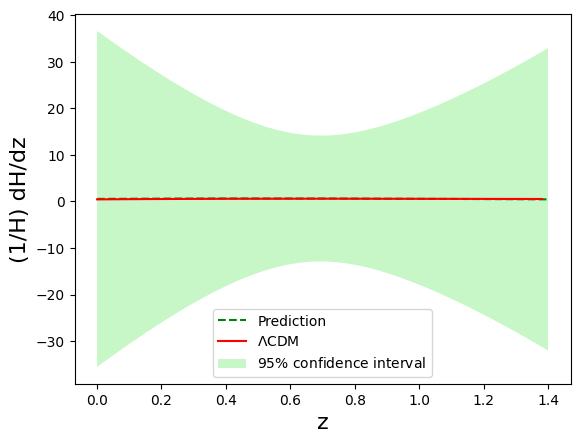

In [45]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# baixando e nomeando dados reconstruídos de H
hz = np.genfromtxt('/content/hz_recon.dat', delimiter='\t')

z_hz = hz[:, 0]
h_hz = hz[:, 1]

ehz = hz[:, 2]

# baixando e nomeando dados reconstruídos da derivada de H
dhz = np.genfromtxt('/content/dhz_recon_newz.dat', delimiter='\t')

z_dhz = dhz[:, 0]

dh = dhz[:, 1]

edh = dhz[:, 2]

dh_h = dh / h_hz  # H'/H

sigma_H = np.sqrt(((dh_h) ** 2) * (((ehz / h_hz) ** 2) + ((edh / dh) ** 2)))


# PLOTE
plt.plot(z_dhz, dh_h, color='green', label='Prediction', linestyle="--")
plt.plot(z, dh_1, color='red', label='$\Lambda$CDM')
plt.fill(np.concatenate([z_dhz, z_dhz[::-1]]),
         np.concatenate([dh_h - 1.9600 * sigma,
                        (dh_h + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label='$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/H) dH/dz', fontsize=16)
plt.legend(loc='best')
plt.show()


# salvando os dados reconstruídos

dH = xi, y_pred, sigma_H
np.savetxt('dh_h_recon_newz.dat', np.transpose(dH), delimiter='\t')
#from google.colab import files
#files.download("dh_h_recon_newz.dat")

Usaremos o que obtivemos de $H'/H$ para plotar $\frac{\Omega_m '}{\Omega_m}$.

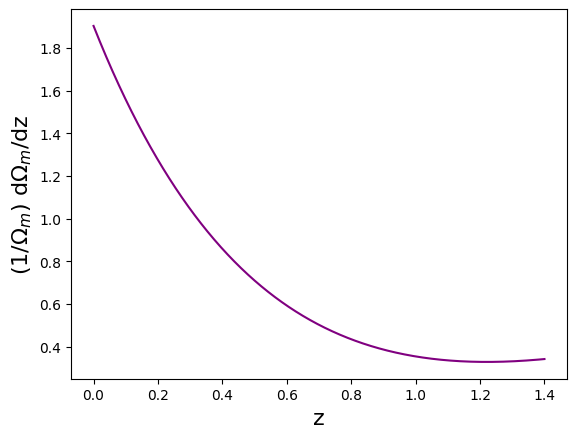

In [46]:
# definindo Om'/Om

dOm_Om = (3/(1+z_dhz)) - (2*dh_h)   #dh_h vem da reconstrução dos dados

eOm = np.sqrt( (2*sigma_H)**2 )

plt.plot(z_dhz, dOm_Om, color='purple')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/$\Omega_m$) d$\Omega_m$/dz', fontsize=16)
plt.show()

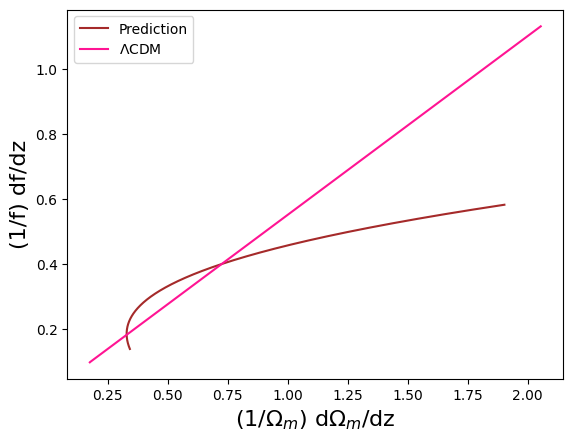

In [47]:
plt.plot(dOm_Om, df_f, color='brown', label='Prediction')
plt.plot(dOmega_new, derivada_flinder, color='deeppink', label='$\Lambda$CDM')

# legenda, label e título
plt.xlabel('(1/$\Omega_m$) d$\Omega_m$/dz', fontsize=16)
plt.ylabel('(1/f) df/dz', fontsize=16)
plt.legend()
plt.show()

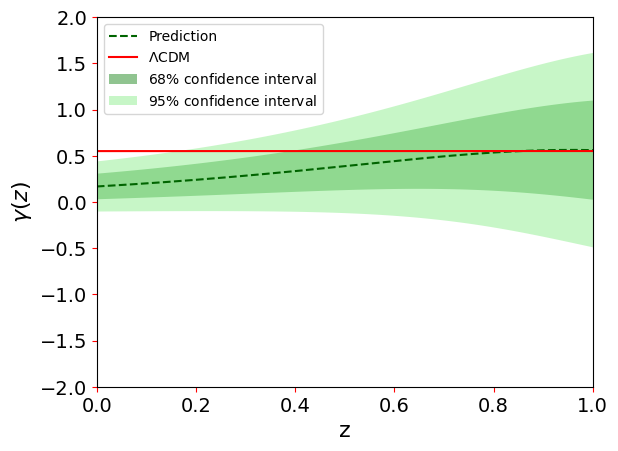

In [51]:
# reconstrução de f'/f
df_f = np.genfromtxt('/content/drive/MyDrive/Doutorado/df_f_recon.dat', delimiter='\t')

dff = df_f[:, 1]

edff = df_f[:, 2]

# reconstrução de Om'/Om
dOm_Om = (3/(1+z_dhz)) - (2*dh_h)   #dh_h vem da reconstrução dos dados

eOm = np.sqrt( (2*sigma_H)**2 )


# gamma LCDM
gamma_lcdm = derivada_flinder / dOmega_new


# gamma prediction

gamma_pred = dff / dOm_Om

sigma_g = np.sqrt( (edff / dOm_Om )**2 + ( ( (dff*eOm)/ ((dOm_Om)**2) ) )**2)

# PLOTE

plt.ylim(-2,2)
plt.xlim(0,1.0)
plt.tick_params(labelsize=14, color='red')
plt.plot(z_dhz, gamma_pred, color='darkgreen', label='Prediction', linestyle="--")
plt.plot(z, gamma_lcdm, color='red', label='$\Lambda$CDM')
plt.fill(np.concatenate([z_dhz, z_dhz[::-1]]),
         np.concatenate([gamma_pred - 1.0000 * sigma_g,
                        (gamma_pred + 1.0000 * sigma_g)[::-1]]),
         alpha=.5, fc='forestgreen', ec='None', label='$68\%$ confidence interval')
plt.fill(np.concatenate([z_dhz, z_dhz[::-1]]),
         np.concatenate([gamma_pred - 1.9600 * sigma_g,
                        (gamma_pred + 1.9600 * sigma_g)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label='$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('$\gamma(z)$', fontsize=16)
plt.legend(loc='best')
plt.show()